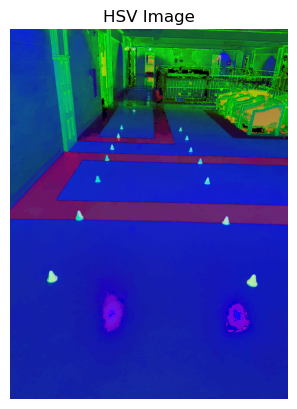

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'red.png'  # Replace with your image path
image = cv2.imread(image_path)

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.figure("HSV image")
plt.title("HSV Image")
plt.imshow(hsv)
plt.axis(False)
plt.show()


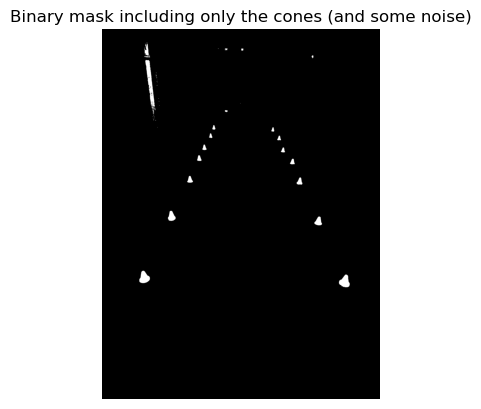

In [19]:

# Define the range of red color in HSV
# The red color in HSV space wraps around 0 and 180, so we need two ranges and then combine them
# I used the output of the hsv to determine the values for the thresholds
lower_red1 = np.array([0, 135, 135])
upper_red1 = np.array([20, 255, 255])
lower_red2 = np.array([170, 135, 135])
upper_red2 = np.array([179, 255, 255])

# Threshold the HSV image to get only red colors
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = cv2.bitwise_or(mask1, mask2)

# Apply morphological operations to remove noise and improve the detection of cones
kernel = np.ones((2, 2), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=2)
mask = cv2.erode(mask, kernel, iterations=1)
plt.figure(2)
plt.title("Binary mask including only the cones (and some noise)")
plt.imshow(mask, cmap='gray')
plt.axis(False)
plt.show()


In [20]:

# Find contours in the mask using openCV findCountours()
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the centers of the contours
# Now find the center of cones from the moments value of the contours for different objects identified in the image. 
centers = []
for c in contours:
    # Filter by contour area to remove small false positives
    # Value 300 is taken by trial and error as it was removing 95% of the noise in the image.
    if cv2.contourArea(c) > 300:
        M = cv2.moments(c)
        if M["m00"] != 0:   # Checking if the 0th moment i.e. area of the object is not 0
            cX = int(M["m10"] / M["m00"])    # Formula to get the x coordinate of the centroid of the object
            cY = int(M["m01"] / M["m00"])    # Formula to get the y coordinate of the centroid of the object
            centers.append((cX, cY))
            # Draw the center of the shape on the image for visual verification
            cv2.circle(image, (cX, cY), 7, (0, 255, 0), -1)

# Note: There are two extra points on the right that is also being detected. Since their y-coordinates are less than the rest of the point
# This is a hack I applied in the interest of time.
centers = [center for center in centers if center[1] > 400]

# Sort the centers based on their x-coordinates
centers.sort(key=lambda x: x[0])


# Separating the left and right path centers.
left_path_centers = centers[:len(centers)//2]
right_path_centers = centers[len(centers)//2:]

print("Coordinates of the left cones: " , left_path_centers)
print("Coordinates of the right cones: ", right_path_centers)


Coordinates of the left cones:  [(275, 1626), (454, 1226), (574, 986), (634, 846), (668, 776), (709, 699), (730, 645)]
Coordinates of the right cones:  [(1115, 658), (1157, 714), (1182, 793), (1244, 869), (1291, 998), (1413, 1259), (1585, 1652)]


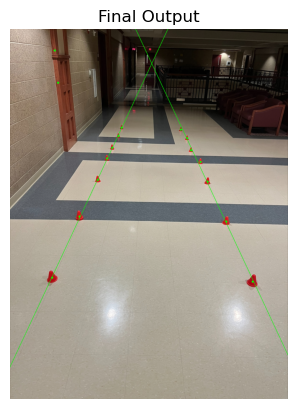

In [21]:

# Fit lines to the center points of the leftmost and rightmost cones
# Finding the left\right vector and a center point in the left\right array of cones
left_vx, left_vy, left_x, left_y = cv2.fitLine(np.array(left_path_centers, dtype=np.int32), cv2.DIST_L2, 0, 0.01, 0.01)
right_vx, right_vy, right_x, right_y = cv2.fitLine(np.array(right_path_centers, dtype=np.int32), cv2.DIST_L2, 0, 0.01, 0.01)

# Define the function to draw the line given the line parameters and image
def draw_fit_line(image, vx, vy, x0, y0):
    y1 = int((-x0*vy/vx) + y0)
    y2 = int(((image.shape[1]-x0)*vy/vx)+y0)
    cv2.line(image, (image.shape[1]-1, y2), (0, y1), (0, 255, 0), 2)

# Draw the fit lines on the image
draw_fit_line(image, left_vx, left_vy, left_x, left_y)
draw_fit_line(image, right_vx, right_vy, right_x, right_y)

# Save the resulting image
cv2.imwrite("answer.png", image)

# For showing in the notebook:
output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(3)
plt.title("Final Output")
plt.imshow(output)
plt.axis(False)
plt.show()
